<a href="https://colab.research.google.com/github/elariekerboull/master_uppsala/blob/main/Exercise_9_autoencoders_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoencoders Lab - Erwan Larié
#### visualizing HapMap phase 3 populations

**This is a solution template. Every chunk of code requiring your input will begin with the # TASK comment and all places where you should fill-in with your code are marked by ellipsis (...).**

### Stage 0 &mdash; getting the data

First, we will download the data from the linked Dropbox account. The code is hidden as it is not super important here. Double-click below if you are curious to see it!



In [2]:
#@title Load raw data. Double click to see the code. { display-mode: "form" }

!wget https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
!wget https://www.dropbox.com/s/3lv0062dw20qdqg/autosomal_5k_phenos.csv
!wget https://www.dropbox.com/s/6nzrusxkm536a5j/autosomal_5k_kinship.csv

--2024-12-17 22:53:23--  https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/a6mehjrpky5u3kwqle74i/autosomal_5k_matrix.csv?rlkey=1iufpj9nhjrm9q3f9ah0msq1d [following]
--2024-12-17 22:53:23--  https://www.dropbox.com/scl/fi/a6mehjrpky5u3kwqle74i/autosomal_5k_matrix.csv?rlkey=1iufpj9nhjrm9q3f9ah0msq1d
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3fd35da159a16a599334b57cdd.dl.dropboxusercontent.com/cd/0/inline/Cgf77lra64s6iN57NVKLA6rm6kZlZiNT5bYfxBkiQ15iWgUc3t6tODGnNX_K0ovpkP8_POh99cVCYvR9zJP0soZcGcGlTgIyTFBDGcdL7op8Qeh5YNrSTtX_DWeEJqrMRA8/file# [following]
--2024-12-17 22:53:24--  https://uc3fd35da159a16a599334b57cdd.dl.dropboxusercontent.com/c

Now, we will load the data and make sure they look as expected. Note, the genotypes per individual (row) are encoded as the count of minor alleles and thus can take values `gt = {0, 1, 2}`.

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

data = pd.read_csv("autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("autosomal_5k_phenos.csv", header=0, index_col=0)

print(data)
print(pheno)


         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919         2           1           0           1           1          0   
NA19916         1           0           0           1           1          0   
NA19835         0           0           1           1           0          1   
NA20282         1           1           0           1           0          0   
NA19703         0           0           0           0           1          1   
...           ...         ...         ...         ...         ...        ...   
NA19119         1           0           1           0           1          1   
NA18860         1           0           0           1           1          0   
NA19207         2           0           0           0           1          0   
NA19103         1           0           1           0           0          0   
NA19099         0           0           1           1           0          1   

         rs882529  rs3885937  rs537330 

Now, we will create a dictionary and re-name our populations so that the names are a bit more informative:

In [4]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA
NA19703,NA19703,1,2368,0,0,0,African ancestry in SW USA
...,...,...,...,...,...,...,...
NA19119,NA19119,1,Y060,0,0,0,Yoruba in Ibadan Nigeria
NA18860,NA18860,1,Y012,NA18859,NA18858,0,Yoruba in Ibadan Nigeria
NA19207,NA19207,1,Y051,0,0,0,Yoruba in Ibadan Nigeria
NA19103,NA19103,1,Y042,NA19101,NA19102,0,Yoruba in Ibadan Nigeria


In [5]:
print("Number of individuals", len(pheno2['id']))

#print(type(pheno2))
value_counts_mom = pheno2[pheno2['mom']!='0']['mom'].value_counts()
print(value_counts_mom)
duplicates_mom = value_counts_mom[value_counts_mom > 1]
print("Duplicate mom ID", len(duplicates_mom))

value_counts_dad = pheno2[pheno2['dad']!='0']['dad'].value_counts()
print(value_counts_dad)
duplicates_dad = value_counts_dad[value_counts_dad > 1]
print("Duplicate dad ID", len(duplicates_dad))

value_counts_dif = pheno2['FID'].value_counts()
single_families = value_counts_dif[value_counts_dif < 2]
print("There are ", len(value_counts_dif), "families, including ", len(single_families), "families of only one person and ", len(value_counts_dif) - len(single_families) , "families of at least 2 persons" )

Number of individuals 1184
mom
NA19909    1
NA21600    1
NA21635    1
NA21686    1
NA21360    1
          ..
NA12156    1
NA06985    1
NA12815    1
NA12236    1
NA19102    1
Name: count, Length: 189, dtype: int64
Duplicate mom ID 0
dad
NA19908    1
NA21485    1
NA21344    1
NA21316    1
NA21583    1
          ..
NA12144    1
NA12812    1
NA12003    1
NA12750    1
NA19101    1
Name: count, Length: 175, dtype: int64
Duplicate dad ID 0
There are  770 families, including  563 families of only one person and  207 families of at least 2 persons


From the data as is we observe no sibling or half-siblings.

In [6]:
value_counts_pop = pheno2['population'].value_counts()
print(value_counts_pop)

value_counts_sex = pheno2['sex'].value_counts()
print(value_counts_sex)



population
Maasai in Kinyawa Kenya                          171
Yoruba in Ibadan Nigeria                         167
Utah residents with N and W European ancestry    165
Luhya in Webuye Kenya                             90
Gujarati Indians in Houston Texas                 88
Toscans in Italy                                  88
Japanese in Tokyo Japan                           86
Chinese in Metropolitan Denver Colorado           85
Han Chinese in Beijing China                      84
African ancestry in SW USA                        83
Mexican ancestry in Los Angeles California        77
Name: count, dtype: int64
sex
0    595
1    589
Name: count, dtype: int64


In [7]:
unique_pop = pheno2['population'].unique()
print(unique_pop)

for pop in unique_pop:
  value_counts_sex_pop = pheno2[pheno2['population'] == pop]['sex'].value_counts()
  print(pop, value_counts_sex_pop)



['African ancestry in SW USA'
 'Utah residents with N and W European ancestry'
 'Han Chinese in Beijing China' 'Chinese in Metropolitan Denver Colorado'
 'Gujarati Indians in Houston Texas' 'Japanese in Tokyo Japan'
 'Luhya in Webuye Kenya' 'Mexican ancestry in Los Angeles California'
 'Maasai in Kinyawa Kenya' 'Toscans in Italy' 'Yoruba in Ibadan Nigeria']
African ancestry in SW USA sex
0    45
1    38
Name: count, dtype: int64
Utah residents with N and W European ancestry sex
0    85
1    80
Name: count, dtype: int64
Han Chinese in Beijing China sex
0    42
1    42
Name: count, dtype: int64
Chinese in Metropolitan Denver Colorado sex
0    44
1    41
Name: count, dtype: int64
Gujarati Indians in Houston Texas sex
1    45
0    43
Name: count, dtype: int64
Japanese in Tokyo Japan sex
1    44
0    42
Name: count, dtype: int64
Luhya in Webuye Kenya sex
1    45
0    45
Name: count, dtype: int64
Mexican ancestry in Los Angeles California sex
0    43
1    34
Name: count, dtype: int64
Maasai 

In [8]:
# TASK Scaling
# We need to scale our counts data so that it is bound between 0 and 1.

geno_data = data/2
geno_data

,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,1.0,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0.5,...,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0
NA19916,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0
NA19835,0.0,0.0,0.5,0.5,0.0,0.5,0.0,1.0,1.0,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
NA20282,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0
NA19703,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0,...,0.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,0.5,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
NA18860,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,0.5,...,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
NA19207,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0
NA19103,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0


In [9]:
# TASK Randomly split into the training and the validation set, so that 80 per-cent of individuals ends up in the training set.

train = geno_data.sample(frac = 0.8, random_state = 42)
test = geno_data.drop(train.index)
train.reset_index()
test.reset_index()

# TASK Print some info about the resulting split
print("Total number of individuals:", geno_data.shape[0])
print("\t - training set:", train.shape[0])
print("\t - test set:", test.shape[0])

Total number of individuals: 1184
	 - training set: 947
	 - test set: 237


In [10]:
# TASK Specify the autoencoder model

train_tensor = train.to_numpy()
print(type(train_tensor))

# TASK Hyperparameters
# use ReLu activations, ADAM optimizer and
# mean squared error as the loss function
hp_loss_fn = "mse"
hp_act_fn = "relu"
hp_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
hp_metrics = ['mse','mae','mape']

input_data = keras.Input(shape = (train_tensor.shape[1],))

# TASK Define architecture of the encoder:
# the second layer should be a batch normalization

def Encoder(input):
  # Encoder
  layer1 = layers.Dense(units = 1500, activation = hp_act_fn, name='layer1')(input)
  layer2 = layers.BatchNormalization(name='layer2')(layer1)
  layer3 = layers.Dropout(rate = 0.05, name='layer3')(layer2)
  layer4 = layers.Dense(units = 250, activation = hp_act_fn, name='layer4')(layer3)
  layer5 = layers.Dropout(rate = 0.025, name='layer5')(layer4)
  layer6 = layers.Dense(units = 25, activation = hp_act_fn, name='layer6')(layer5)
  bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(layer6)
  return(bottleneck)

# TASK Look at the encoder, complete the decoder function

def Decoder(bottleneck):
  # Decoder
  layer7 = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
  layer8 = layers.Dropout(rate = 0.025, name='layer8')(layer7)
  layer9 = layers.Dense(units = 250, activation = hp_act_fn, name='layer9')(layer8)
  layer10 = layers.Dropout(rate = 0.05 , name='layer10')(layer9)
  layer11 = layers.Dense(units=1500,name='layer11')(layer10)
  layer12 = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(layer11)
  return(layer12)

def Autoencoder(input):
  enc = Encoder(input)
  autoenc = Decoder(enc)
  return(autoenc)

autoencoder_model = keras.Model(inputs = input_data, outputs = Autoencoder(input_data))
autoencoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)

# TASK Visualise the created architecture and summarise its parameters
autoencoder_model.summary()

<class 'numpy.ndarray'>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer1 (Dense)                       │ (None, 1500)                │       7,501,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (BatchNormalization)          │ (None, 1500)                │           6,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dropout)                     │ (None, 1500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer4 (Dense)                       │ (None, 250)                 │         375,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer5 (Dropout)                     │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer6 (Dense)                       │ (None, 25)                  │           6,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_bottleneck (Dense)             │ (None, 2)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │              75 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer8 (Dropout)                     │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer9 (Dense)                       │ (None, 250)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer10 (Dropout)                    │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer11 (Dense)                      │ (None, 1500)                │         376,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5000)                │       7,505,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,777,152 (60.19 MB)

 Trainable params: 15,774,152 (60.17 MB)

 Non-trainable params: 3,000 (11.72 KB)

In [11]:
# TASK Set hyperparameters for model fitting
# Begin by training for 30 epochs, with mini-batch of 256 and validation set
# having 20 per-cent of examples

hp_epochs = 30
hp_batch_size = 256
hp_val_split = 0.2

autoencoder = autoencoder_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.1850 - mae: 0.3713 - mape: 341128768.0000 - mse: 0.1850 - val_loss: 0.1845 - val_mae: 0.3694 - val_mape: 340505632.0000 - val_mse: 0.1845
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.1843 - mae: 0.3706 - mape: 340323072.0000 - mse: 0.1843 - val_loss: 0.1842 - val_mae: 0.3692 - val_mape: 340223648.0000 - val_mse: 0.1842
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.1829 - mae: 0.3697 - mape: 338795904.0000 - mse: 0.1829 - val_loss: 0.1838 - val_mae: 0.3689 - val_mape: 339809088.0000 - val_mse: 0.1838
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.1799 - mae: 0.3677 - mape: 335647776.0000 - mse: 0.1799 - val_loss: 0.1832 - val_mae: 0.3685 - val_mape: 339178112.0000 - val_mse: 0.1832
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 908ms/step - loss: 0.1744 - mae: 0.3635 - mape: 329328288.0000 - mse: 0.1744 - val_loss: 0.1823 - val_mae: 0.3678 - val_mape: 338164512.0000 - val_mse: 0.1823
Epoch 6/30
3/3 ━━━━━━

Now, let us look at the training process:

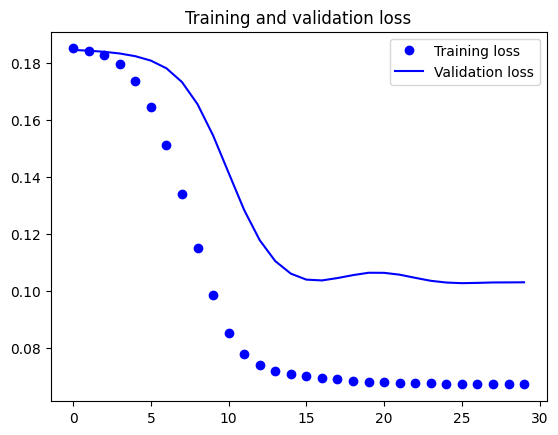

In [12]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Now, that the model is trained, we can save the weights and use them to build an encoder. Note that weights are saved for the entire autoencoder, so we need to use `skip_mismatch = True` along with `by_name = True` to initialize weights in our encoder.

In [21]:
autoencoder_model.save_weights('autoencoder_weights.weights.h5',
                               overwrite = True)

encoder_model = keras.Model(inputs = input_data, outputs = Encoder(input_data))
encoder_model.load_weights('autoencoder_weights.weights.h5',
                           skip_mismatch = True)
encoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)


Let us embed our genotyping data using the encoder we have just constructed.
We can also visualise the embedding.

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
[[-11.100045   -1.9221904]
 [ -7.7105255  -1.6811404]
 [-11.439851    1.1846018]
 ...
 [-10.721948   -1.5288755]
 [-10.680776   -2.8052437]
 [ -9.941294   -4.4735355]]


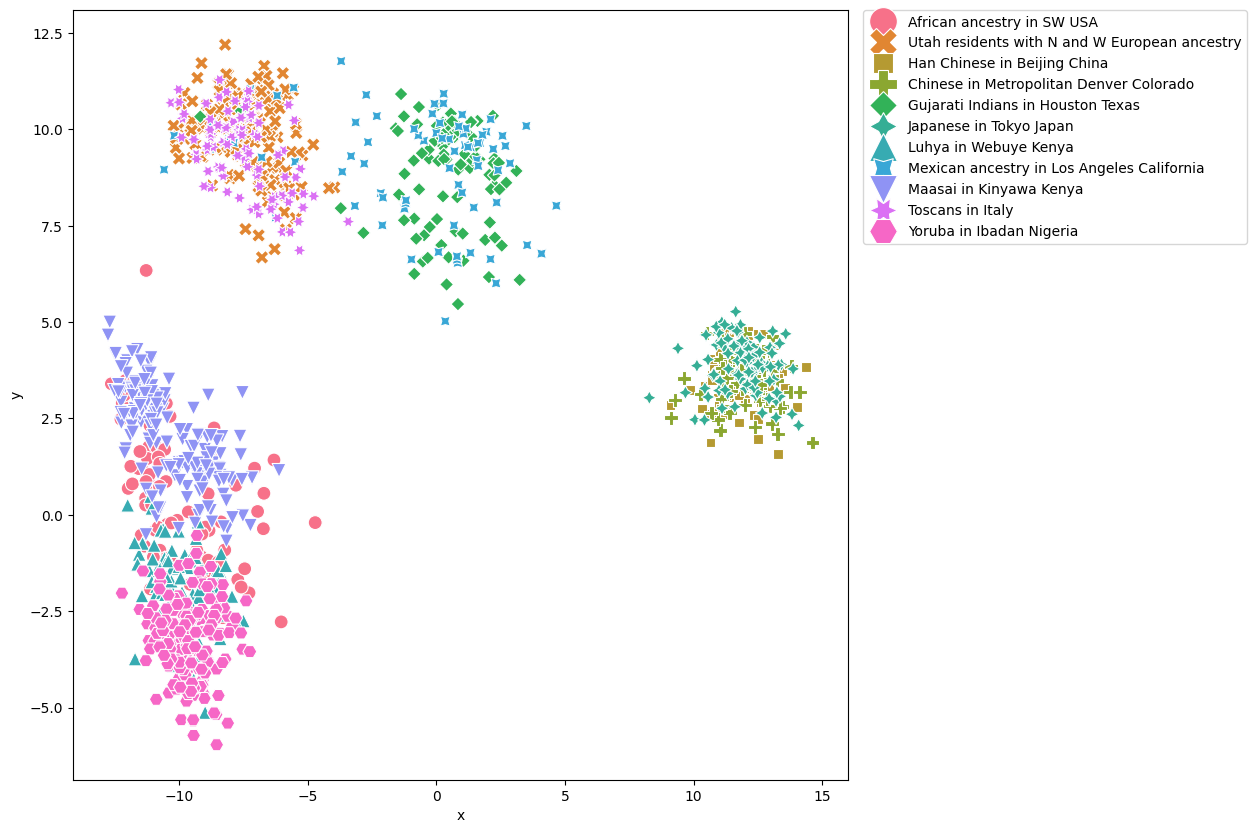

In [54]:
embeded_points = encoder_model.predict(geno_data.to_numpy())
print(embeded_points)

x = embeded_points[:,0]
y = embeded_points[:,1]
pop = pheno2['population']
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Now, we will compare the result with:
* MDS on the kinship matrix
* PCA perfored directly on raw genotypes


In [55]:
kinship = pd.read_csv("autosomal_5k_kinship.csv", header=0, index_col=0)


In [56]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
mds_embedding = embedding.fit_transform(kinship)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:629: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


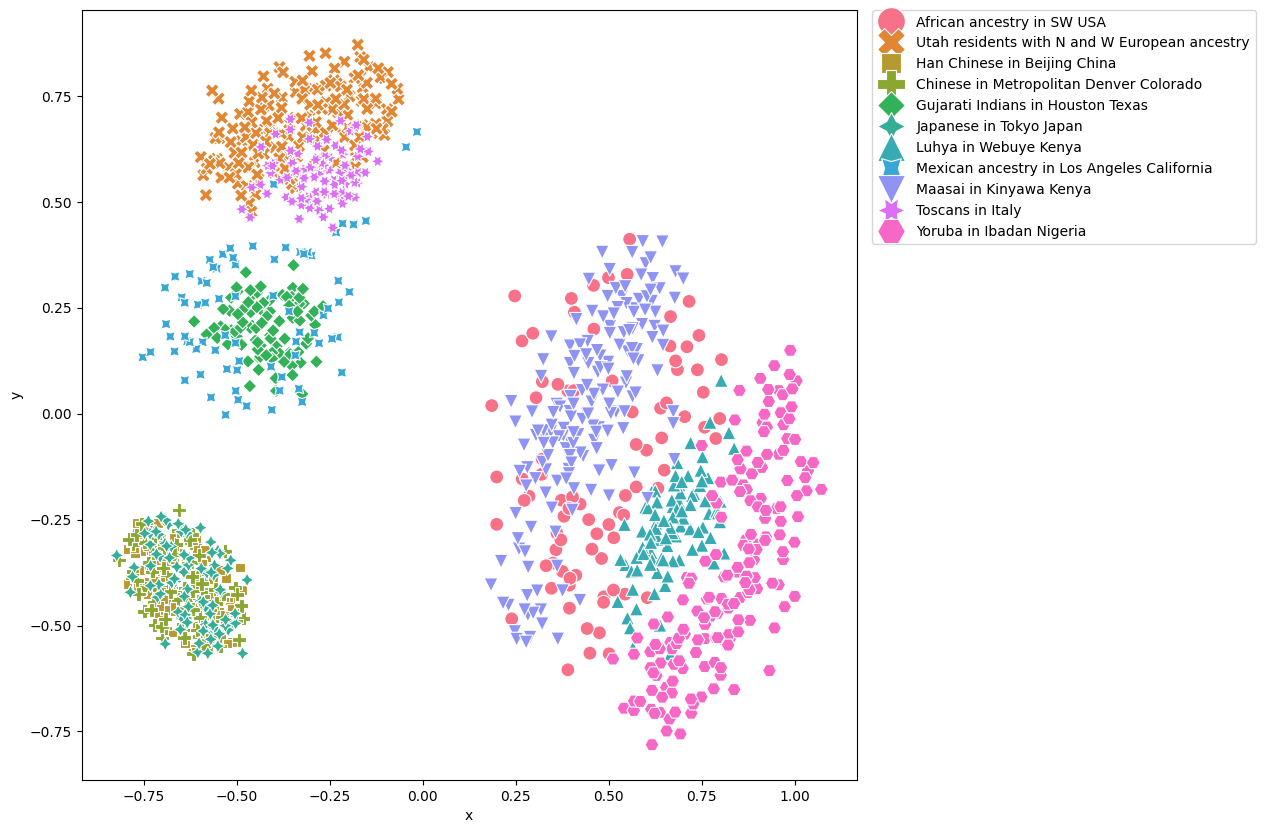

In [57]:
# TASK Plot MDS embedding in a way similar to plotting autoencoder embeddings
x = mds_embedding[:,0]
y = mds_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Finally, we will perform PCA on raw genotypes:

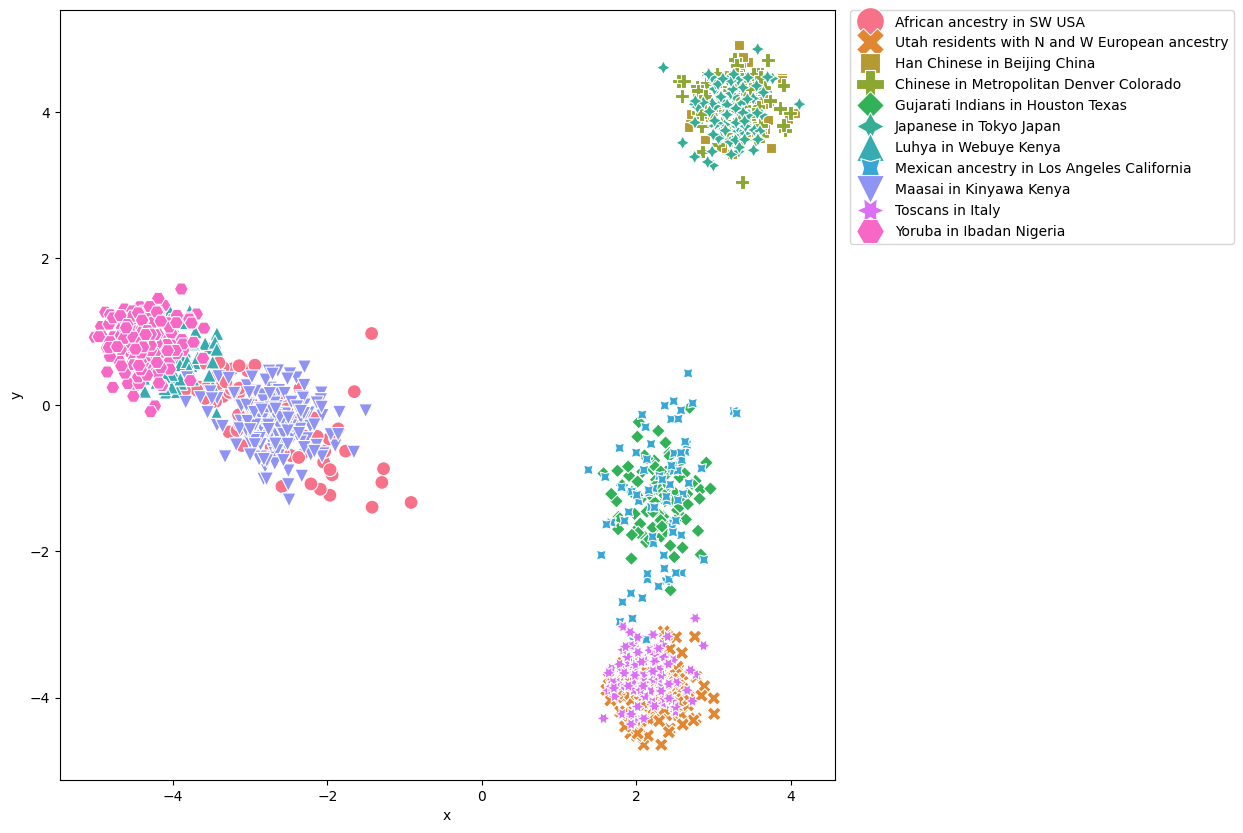

In [24]:
# TASK perform PCA with 2 components on raw genotypes (use geno_data as input but remember it has been scaled)
# Visualise the result.
from sklearn.decomposition import PCA
embedding = PCA(2)
pca_embedding = embedding.fit_transform(geno_data)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

We can look up the name of each locus on https://www.ncbi.nlm.nih.gov/nuccore/ to find out which chromosome a locus is - for instance locus rs11223492 is based on chromosome 11. Without this tool, it is not possible to determine which chromosome is associated to the locus based on the name. \\

We do observe similarities between the three plots that were obtained with identical grouping - however the autoencoder results show a larger spread of the data, as well as more outliers than from MDS and PCA plots. \\
In all plots we can observe gene flow within each group of population with a high gene flow observed in Asian populations compared to African populations. We observe a gene flow between the european and american population groups due to the emigration of europeans to the America.

In [50]:
train = geno_data.sample(frac = 0.8, random_state = 42)
test = geno_data.drop(train.index)
train.reset_index()
test.reset_index()

train_tensor = train.to_numpy()
print(type(train_tensor))

# TASK Hyperparameters
# use ReLu activations, ADAM optimizer and
# mean squared error as the loss function
hp_loss_fn = "mse"
hp_act_fn = "relu"
hp_optimizer = keras.optimizers.Adam(learning_rate=0.0005)
hp_metrics = ['mse','mae','mape']

input_data = keras.Input(shape = (train_tensor.shape[1],))

def Encoder(input):
  # Encoder
  layer1 = layers.Dense(units = 4000, activation = hp_act_fn, name='layer1')(input)
  layer2 = layers.BatchNormalization(name='layer2')(layer1)
  layer3 = layers.Dropout(rate = 0.15, name='layer3')(layer2)
  layer4 = layers.Dense(units = 500, activation = hp_act_fn, name='layer4')(layer3)
  layer5 = layers.Dropout(rate = 0.05, name='layer5')(layer4)
  layer6 = layers.Dense(units = 200, activation = hp_act_fn, name='layer6')(layer5)
  layer7 = layers.Dropout(rate = 0.02, name='layer7')(layer6)
  layer8 = layers.Dense(units = 25, activation = hp_act_fn, name='layer8')(layer7)
  bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(layer8)
  return(bottleneck)

# TASK Look at the encoder, complete the decoder function

def Decoder(bottleneck):
  # Decoder
  layer9 = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
  layer10 = layers.Dropout(rate = 0.02, name='layer10')(layer9)
  layer11 = layers.Dense(units = 200, activation = hp_act_fn, name='layer11')(layer10)
  layer12 = layers.Dropout(rate = 0.05 , name='layer12')(layer11)
  layer13 = layers.Dense(units=500,name='layer13')(layer12)
  layer14 = layers.Dropout(rate = 0.15, name='layer14')(layer13)
  layer15 = layers.Dense(units=500,name='layer15')(layer14)
  layer16 = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(layer15)
  return(layer16)

def Autoencoder(input):
  enc = Encoder(input)
  autoenc = Decoder(enc)
  return(autoenc)

autoencoder_model = keras.Model(inputs = input_data, outputs = Autoencoder(input_data))
autoencoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)

autoencoder_model.summary()

<class 'numpy.ndarray'>


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 5000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer1 (Dense)                       │ (None, 4000)                │      20,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (BatchNormalization)          │ (None, 4000)                │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dropout)                     │ (None, 4000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer4 (Dense)                       │ (None, 500)                 │       2,000,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer5 (Dropout)                     │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer6 (Dense)                       │ (None, 200)                 │         100,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer7 (Dropout)                     │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer8 (Dense)                       │ (None, 25)                  │           5,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_bottleneck (Dense)             │ (None, 2)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 25)                  │              75 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer10 (Dropout)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer11 (Dense)                      │ (None, 200)                 │           5,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer12 (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer13 (Dense)                      │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer14 (Dropout)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer15 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5000)                │       2,505,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,987,052 (95.32 MB)

 Trainable params: 24,979,052 (95.29 MB)

 Non-trainable params: 8,000 (31.25 KB)

In [51]:

hp_epochs = 30
hp_batch_size = 256
hp_val_split = 0.2

autoencoder = autoencoder_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

autoencoder_model.save_weights('autoencoder_weights.weights.h5',
                               overwrite = True)

encoder_model = keras.Model(inputs = input_data, outputs = Encoder(input_data))
encoder_model.load_weights('autoencoder_weights.weights.h5',
                           skip_mismatch = True)
encoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.1848 - mae: 0.3711 - mape: 340919136.0000 - mse: 0.1848 - val_loss: 0.1835 - val_mae: 0.3688 - val_mape: 339416160.0000 - val_mse: 0.1835
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1765 - mae: 0.3657 - mape: 331559424.0000 - mse: 0.1765 - val_loss: 0.1712 - val_mae: 0.3603 - val_mape: 325836896.0000 - val_mse: 0.1712
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.1217 - mae: 0.3068 - mape: 239071968.0000 - mse: 0.1217 - val_loss: 0.1026 - val_mae: 0.2878 - val_mape: 216083168.0000 - val_mse: 0.1026
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0863 - mae: 0.1899 - mape: 54138652.0000 - mse: 0.0863 - val_loss: 0.0746 - val_mae: 0.2202 - val_mape: 131655160.0000 - val_mse: 0.0746
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0836 - mae: 0.1689 - mape: 41771488.0000 - mse: 0.0836 - val_loss: 0.0759 - val_mae: 0.2185 - val_mape: 143327520.0000 - val_mse: 0.0759
Epoch 6/30
3/3 ━━━━━━━━━━━━

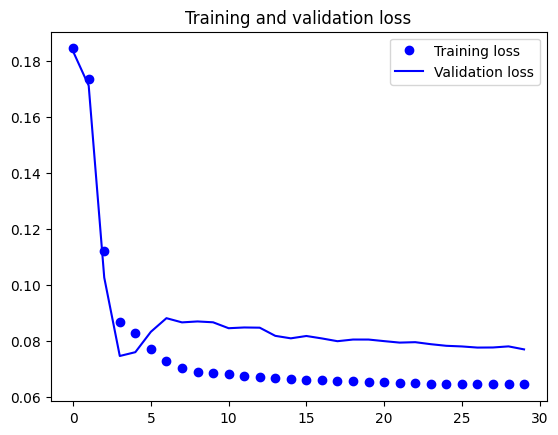

In [52]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [53]:
autoencoder_model.save_weights('autoencoder_weights.weights.h5',
                               overwrite = True)

encoder_model = keras.Model(inputs = input_data, outputs = Encoder(input_data))
encoder_model.load_weights('autoencoder_weights.weights.h5',
                           skip_mismatch = True)
encoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
[[ 4.113439  -5.517477 ]
 [ 4.0585647 -4.8179674]
 [ 3.8020847 -5.751936 ]
 ...
 [ 4.2944436 -5.3831625]
 [ 4.1877384 -5.255868 ]
 [ 4.8943915 -5.3072786]]


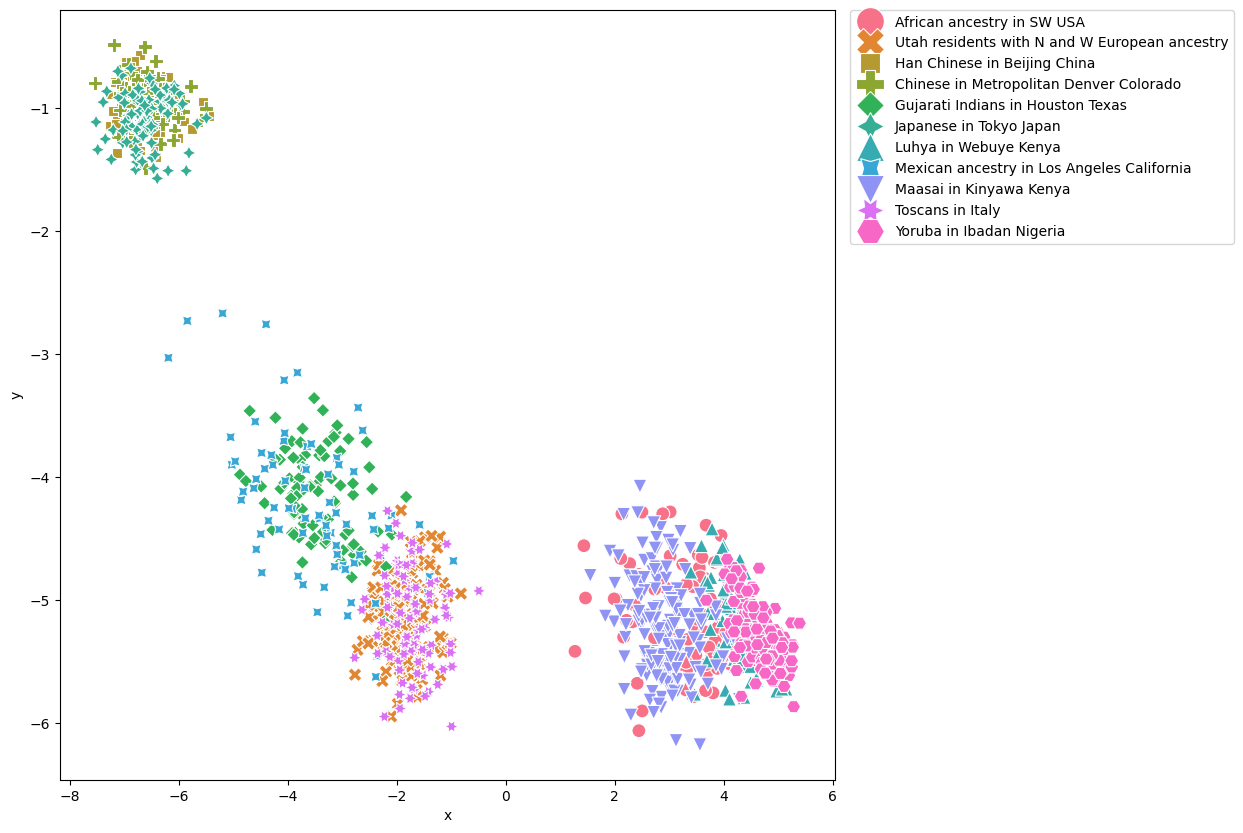

In [54]:
embeded_points = encoder_model.predict(geno_data.to_numpy())
print(embeded_points)

x = embeded_points[:,0]
y = embeded_points[:,1]
pop = pheno2['population']
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Through trial and error and selection of optimal results, we obtain a model that seems to show more precision in the repartition of the data. We can notably observe that some amerindian populations display some proximity to the asian populations, which could be explained by the amerindian population originating from Asia.